In [22]:
%%capture
!pip install xbatcher tensorboard imbalanced-learn

In [23]:
import os
if 'notebooks' in os.getcwd():
    os.chdir("..")

import util
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

# If we have gpu available, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.set_default_device(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB


Prepare data

In [24]:
ds = xr.open_dataset("data_working/westmort.nc")\
    .squeeze(drop=True)\
    .drop_vars("spatial_ref")

In [25]:
# Use EWMA to smooth mortality observations
ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

In [26]:
# Calculate total basal area based on all the genus rasters
ba_vars = ["abies", "picea", "populus", "tsuga", "pseudotsuga"]
ds["forest_ba"] = ds[ba_vars].to_stacked_array("band", sample_dims=["x", "y", "time"]).sum(dim="band")

In [27]:
ds = ds.to_stacked_array("band", sample_dims=["x", "y", "time"])\
    .transpose("time", "band", ...)
ds

<xarray.DataArray 'abies' (time: 27, band: 18, y: 652, x: 590)> Size: 748MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ...,  1.,  1.,  1.],
         [nan, nan, nan, ...,  1.,  1.,  1.],
         [nan, nan, nan, ...,  1.,  1.,  1.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]], dtype=float32)
Coordinates:
  * time      (time) int64 216B 1997 1998 1999 2000 2001 ... 2020 2021 2022 2023
  * x         (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y         (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * band      (band) object 144B MultiIndex
  * variable  (band) <U11 792B 'abies' 'picea' ... 'mort_ewma' 'forest_ba'

Make sure windowing works right

In [28]:
window = dict(x=[16, False], y=[16, False], time=[5, False])
prop_na = 0.8
mort_arr = ds.sel(band="mort_ewma", drop=True)
mort_ds = util.datasets.WindowXarrayDataset(ds, window, mask=mort_arr, na_thresh=prop_na)

print(len(mort_ds))

368742


In [29]:
eg_window = mort_ds[10]
window_x = eg_window.isel(time=slice(None, -1))
window_y = eg_window.isel(time=-1).sel(band="mort_ewma")

In [30]:
assert (1 - np.mean(np.isnan(window_y.values))) > prop_na

Set up model definition

In [31]:
ds.band

<xarray.DataArray 'band' (band: 18)> Size: 144B
array([('abies',), ('picea',), ('populus',), ('pseudotsuga',), ('tsuga',),
       ('vod',), ('elev',), ('slope',), ('northness',), ('eastness',),
       ('fire',), ('mortality',), ('prcp',), ('vp',), ('tmin',),
       ('treecover',), ('mort_ewma',), ('forest_ba',)], dtype=object)
Coordinates:
  * band      (band) object 144B MultiIndex
  * variable  (band) <U11 792B 'abies' 'picea' ... 'mort_ewma' 'forest_ba'

In [32]:
from util.convlstm import DamageConvLSTM

input_bands = ["mort_ewma", "prcp", "elev", "treecover"]
input_inds = np.where(np.isin(ds.coords.get("variable").values, input_bands))[0]
input_channel = len(input_bands)
hidden_dim = 8
num_layers = 2
kernel = (3, 3)

m = DamageConvLSTM(input_channel, hidden_dim, kernel, num_layers, batch_first=True)

Verify that the shapes work out.

In [33]:
fake_input = torch.tensor(window_x.isel(band=input_inds).values).unsqueeze(0).to(torch.float32)
fake_output = m(fake_input)
assert fake_output.shape == window_y.shape

Data pipeline

In [34]:
# Prepare data laoders. Since we are using a 5-year lookback here, each dataset
# has to be temporally disjoint so we don't leak data. Since 2020 had very few
# surveys we have to ignore it.
years = ds.time.values

train_years = years[16:]
valid_years = years[:8]
test_years = years[8:16]

print("Training years:", train_years)
print("Validation years:", valid_years)
print("Testing years:", test_years)

Training years: [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]
Validation years: [1997 1998 1999 2000 2001 2002 2003 2004]
Testing years: [2005 2006 2007 2008 2009 2010 2011 2012]


In [35]:
valid_wds = util.datasets.WindowXarrayDataset(
    ds.sel(time=valid_years), window, 
    mask=mort_arr.sel(time=valid_years),
    na_thresh=prop_na
)
test_wds  = util.datasets.WindowXarrayDataset(
    ds.sel(time=test_years), window, 
    mask=mort_arr.sel(time= test_years), 
    na_thresh=prop_na
)

print("Count of examples")
print("Validation:", len(valid_wds))
print("Testing:", len(test_wds))

Count of examples
Validation: 38421
Testing: 83017


In [36]:
from torch.utils.data import DataLoader

ewma_target_ind = np.where(ds.coords.get("variable").values == "mort_ewma")[0][0]
orig_target_ind = np.where(ds.coords.get("variable").values == "mortality")[0][0]

dtype = torch.float32
# cutoff = 1

def make_collator(input_inds, target_ind):
    def collator(patch_list):
        X = torch.stack([
            torch.tensor(
                np.squeeze(patch.values[:-1, input_inds, :, :]),
                dtype=dtype
            )
            for patch in patch_list
        ])
    
        # Replace nan cells with the channel mean from this batch
        ch_mean = torch.nanmean(X, dim=0)
        X = torch.nan_to_num(X)
        X += ch_mean * torch.isnan(X)
        
        y = torch.stack([
            torch.tensor(patch.values[-1, target_ind, :, :], dtype=dtype)
            for patch in patch_list
        ]).squeeze(dim=2)/100
    
        return X, y

    return collator

ewma_collator = make_collator(input_inds, ewma_target_ind)
orig_collator = make_collator(input_inds, orig_target_ind)

batch_size = 32

# Setting the RNG to host device is necessary if we want to run on GPU
valid_loader = DataLoader(
    valid_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=ewma_collator, 
    generator=torch.Generator(device=device)
)
test_loader  = DataLoader(
    test_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=ewma_collator, 
    generator=torch.Generator(device=device)
)

In [37]:
# Again make sure the sizes work out
X, y = tuple(next(iter(valid_loader)))
print(X.shape)
out = m(X)
print(out.shape)
assert out.shape == y.shape

torch.Size([32, 4, 4, 16, 16])
torch.Size([32, 16, 16])


In [38]:
reload(util.datasets)

<module 'util.datasets' from '/home/jovyan/ForestLST/util/datasets.py'>

In [39]:
import torchmetrics
from util.convlstm import DamageConvLSTM

wds = util.datasets.WindowXarrayDataset(
    ds.sel(time=train_years), window, mask=mort_arr.sel(time=train_years), na_thresh=prop_na
)
print(f"N: {len(wds)}")

train_loader = DataLoader(
    wds, batch_size, 
    shuffle=True, collate_fn=ewma_collator, 
    generator=torch.Generator(device=device)
)

N: 88114


In [40]:
reload(util.training)
from util.training import BaseTrainer, ReduceLRMixin, EarlyStopMixin, MaskedLossMixin

class Trainer(MaskedLossMixin, ReduceLRMixin, EarlyStopMixin, BaseTrainer):
    pass

In [41]:
# Model params
input_channel = len(input_bands)
hidden_dim = 5
num_layers = 2
kernel = (5, 5)
m = DamageConvLSTM(
    input_channel, 
    hidden_dim, 
    kernel, 
    num_layers, 
    batch_first=True,
    dropout=0.3
)
print("N params:", util.training.count_trainable_parameters(m))

# Init bias - this is just a guess but it doesn't have
# to be perfect.
mean_mort = 0.03
init_bias = np.log(mean_mort / (1 - mean_mort))
torch.nn.init.constant_(m.conv.bias, init_bias)

# Build trainer
loss = torch.nn.MSELoss()
opt  = torch.optim.Adam(m.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, factor=0.2, threshold=0.01)
metrics = util.training.get_regr_metrics()

model_name = f"03202025_convlstm__16_16_5__ewma__4band"
logdir = os.path.join("logs", model_name)

# Remove existing logs if present
if os.path.exists(logdir):
    util.training.remove_log(logdir)

trainer = Trainer(
    m, opt, scheduler, loss, train_loader, valid_loader,
    metrics=metrics, 
    n_epochs=30,
    tensorboard_log=os.path.join(logdir, "history"),
    model_log=os.path.join(logdir, "model.pth"),
    defn_log=os.path.join(logdir, "model_definition.txt"),
    verbose=True,
    stop_patience=5,
    rel_improve=0.01,
)

trainer.train()

N params: 9554


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training loss:   0%|          | 0/2754 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/1201 [00:00<?, ?it/s]

Epoch 1 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.001897
2                               Loss/valid  tensor(0.0024)
3                MeanAbsoluteError()/train     0.020100705
4                MeanAbsoluteError()/valid     0.015144691
5                 MeanSquaredError()/train    0.0018972702
6                 MeanSquaredError()/valid    0.0024444868
7   NormalizedRootMeanSquaredError()/train        1.639182
8   NormalizedRootMeanSquaredError()/valid        2.273624
9                  PearsonCorrCoef()/train      0.77049917
10                 PearsonCorrCoef()/valid       0.6777265



Training loss:   0%|          | 0/2754 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/1201 [00:00<?, ?it/s]

Epoch 2 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.001636
2                               Loss/valid  tensor(0.0024)
3                MeanAbsoluteError()/train      0.01760537
4                MeanAbsoluteError()/valid     0.014922446
5                 MeanSquaredError()/train    0.0016358136
6                 MeanSquaredError()/valid    0.0024168536
7   NormalizedRootMeanSquaredError()/train        1.522053
8   NormalizedRootMeanSquaredError()/valid       2.2607338
9                  PearsonCorrCoef()/train       0.8064143
10                 PearsonCorrCoef()/valid      0.67191344



Training loss:   0%|          | 0/2754 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/1201 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 3 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.001585
2                               Loss/valid  tensor(0.0024)
3                MeanAbsoluteError()/train       0.0169279
4                MeanAbsoluteError()/valid    0.0146709215
5                 MeanSquaredError()/train    0.0015852927
6                 MeanSquaredError()/valid    0.0023600857
7   NormalizedRootMeanSquaredError()/train       1.4983625
8   NormalizedRootMeanSquaredError()/valid       2.2340236
9                  PearsonCorrCoef()/train      0.81351215
10                 PearsonCorrCoef()/valid       0.6780775



Training loss:   0%|          | 0/2754 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/1201 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 4 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.001562
2                               Loss/valid  tensor(0.0025)
3                MeanAbsoluteError()/train     0.016633872
4                MeanAbsoluteError()/valid     0.014833161
5                 MeanSquaredError()/train     0.001561364
6                 MeanSquaredError()/valid    0.0025033583
7   NormalizedRootMeanSquaredError()/train       1.4870133
8   NormalizedRootMeanSquaredError()/valid       2.3008373
9                  PearsonCorrCoef()/train       0.8168252
10                 PearsonCorrCoef()/valid       0.6793023



Training loss:   0%|          | 0/2754 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/1201 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 5 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.001553
2                               Loss/valid  tensor(0.0025)
3                MeanAbsoluteError()/train     0.016524507
4                MeanAbsoluteError()/valid     0.014890722
5                 MeanSquaredError()/train    0.0015530067
6                 MeanSquaredError()/valid    0.0024544466
7   NormalizedRootMeanSquaredError()/train        1.483029
8   NormalizedRootMeanSquaredError()/valid       2.2782502
9                  PearsonCorrCoef()/train        0.817992
10                 PearsonCorrCoef()/valid       0.6752015



Training loss:   0%|          | 0/2754 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/1201 [00:00<?, ?it/s]

Epoch 6 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.001542
2                               Loss/valid  tensor(0.0025)
3                MeanAbsoluteError()/train      0.01642853
4                MeanAbsoluteError()/valid     0.014778813
5                 MeanSquaredError()/train    0.0015412533
6                 MeanSquaredError()/valid    0.0024481772
7   NormalizedRootMeanSquaredError()/train       1.4774035
8   NormalizedRootMeanSquaredError()/valid       2.2753365
9                  PearsonCorrCoef()/train       0.8195615
10                 PearsonCorrCoef()/valid       0.6732937



Training loss:   0%|          | 0/2754 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/1201 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 7 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001539
2                               Loss/valid  tensor(0.0025)
3                MeanAbsoluteError()/train     0.016380781
4                MeanAbsoluteError()/valid     0.014700852
5                 MeanSquaredError()/train    0.0015391067
6                 MeanSquaredError()/valid    0.0024543055
7   NormalizedRootMeanSquaredError()/train       1.4763778
8   NormalizedRootMeanSquaredError()/valid        2.278184
9                  PearsonCorrCoef()/train        0.819896
10                 PearsonCorrCoef()/valid      0.67511857



Training loss:   0%|          | 0/2754 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/1201 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 8 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001495
2                               Loss/valid  tensor(0.0024)
3                MeanAbsoluteError()/train      0.01614459
4                MeanAbsoluteError()/valid     0.014592876
5                 MeanSquaredError()/train    0.0014944976
6                 MeanSquaredError()/valid    0.0024066244
7   NormalizedRootMeanSquaredError()/train       1.4548203
8   NormalizedRootMeanSquaredError()/valid        2.255948
9                  PearsonCorrCoef()/train       0.8256407
10                 PearsonCorrCoef()/valid       0.6751812



Training loss:   0%|          | 0/2754 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/1201 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001485
2                               Loss/valid  tensor(0.0025)
3                MeanAbsoluteError()/train     0.016076205
4                MeanAbsoluteError()/valid     0.014696724
5                 MeanSquaredError()/train    0.0014843706
6                 MeanSquaredError()/valid    0.0024496154
7   NormalizedRootMeanSquaredError()/train       1.4498866
8   NormalizedRootMeanSquaredError()/valid       2.2760062
9                  PearsonCorrCoef()/train       0.8269685
10                 PearsonCorrCoef()/valid      0.67644304



(<Figure size 640x480 with 6 Axes>,
 <Axes: title={'center': 'PearsonCorrCoef()'}>)

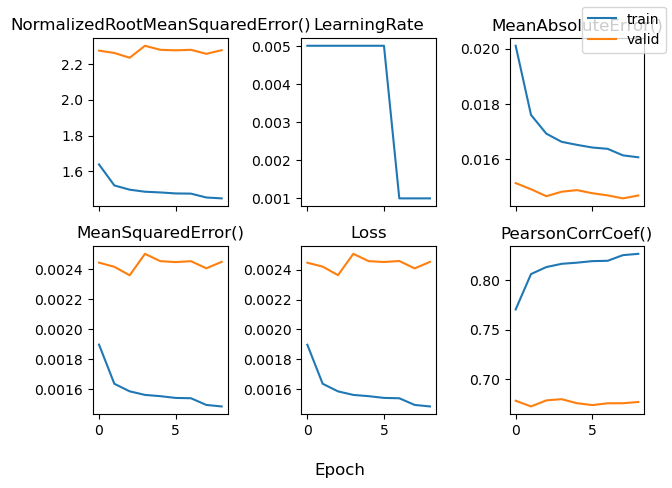

In [42]:
util.plot.plot_all_scalars_in_run(f"logs/{model_name}/history/")

Calculate performance on test set

In [45]:
from tqdm import tqdm
import pandas as pd

test_metrics = util.training.get_regr_metrics()

m.eval()
with torch.no_grad():
    for (X, y) in tqdm(test_loader, leave=False):
        y_hat = m(X)
        mask = ~torch.isnan(y)
        
        for metric in test_metrics:
            metric(y_hat[mask].view(-1), y[mask].view(-1))

for metric in test_metrics:
    print(f"{str(metric)}: {metric.compute():.3f}")

NormalizedRootMeanSquaredError(): 1.931
PearsonCorrCoef(): 0.773
MeanAbsoluteError(): 0.008
MeanSquaredError(): 0.001


In [82]:
test_metrics[-1].compute().cpu().numpy()

array(0.0006689, dtype=float32)

What if we test/validate on the smoothed signal?

In [46]:
train_metrics = util.training.get_final_metrics(f"logs/{model_name}/history")

In [47]:
train_metrics

{'NormalizedRootMeanSquaredError()/train': 1.4498865604400635,
 'PearsonCorrCoef()/train': 0.8269684910774231,
 'MeanAbsoluteError()/train': 0.016076205298304558,
 'MeanSquaredError()/train': 0.001484370557591319,
 'NormalizedRootMeanSquaredError()/valid': 2.2760062217712402,
 'PearsonCorrCoef()/valid': 0.6764430403709412,
 'MeanAbsoluteError()/valid': 0.014696723781526089,
 'MeanSquaredError()/valid': 0.002449615392833948,
 'Loss/train': 0.0014845762634649873,
 'Loss/valid': 0.0024517090059816837,
 'LearningRate': 0.0010000000474974513}

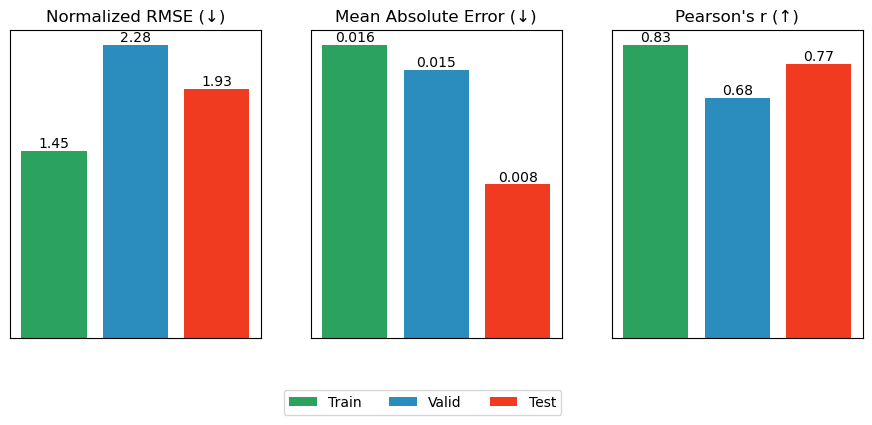

In [52]:
from matplotlib.patches import Rectangle

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 4))

nrmse = "NormalizedRootMeanSquaredError()"
mae = "MeanAbsoluteError()"
rho = "PearsonCorrCoef()"

label = ["Train", "Valid", "Test"]
color = ["#2ca25f", "#2b8cbe", "#f03b20"]

nrmse_values = [
    train_metrics[f"{nrmse}/train"],
    train_metrics[f"{nrmse}/valid"], 
    test_metrics[0].compute().cpu(), 
]
r2_values = [
    train_metrics[f"{rho}/train"], 
    train_metrics[f"{rho}/valid"], 
    test_metrics[1].compute().cpu(), 
]
mae_values = [
    train_metrics[f"{mae}/train"], 
    train_metrics[f"{mae}/valid"], 
    test_metrics[2].compute().cpu(), 
]
x = [0, 1, 2]

ax1.set_title("Normalized RMSE (↓)")
b = ax1.bar(x, nrmse_values, label=label, color=color)
ax1.bar_label(b, fmt="%.2f")
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

ax3.set_title("Pearson's r (↑)")
b = ax3.bar(x, r2_values, label=label, color=color)
ax3.bar_label(b, fmt="%.2f")
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
# ax2.legend()

ax2.set_title("Mean Absolute Error (↓)")
b = ax2.bar(x, mae_values, label=label, color=color)
ax2.bar_label(b, fmt="%.3f")
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
# ax2.legend()

handles, labels = ax1.get_legend_handles_labels()

plt.legend(handles, labels, ncol=3, loc = 'lower center', bbox_to_anchor = (0, -0.1, 1, 1),
           bbox_transform = plt.gcf().transFigure)
# fig.tight_layout()

Prediction map

In [67]:
ds_infer = ds.sel(time=np.concatenate([valid_years, test_years]))
wds_infer = util.datasets.WindowXarrayDataset(
    ds_infer, window, 
    mask=ds_infer.sel(band="mortality"), 
    na_thresh=0.5,
    downsample_step=10
)
print(len(wds_infer))

49442


In [71]:
ch_means = m.bn.running_mean.unsqueeze(-1).unsqueeze(-1)

def inference_collator(patch):
    X = torch.tensor(
            np.squeeze(patch.values[:-1, input_inds, :, :]),
            dtype=dtype
        ).unsqueeze(0)

    # Replace nan cells with the channel mean
    X = torch.nan_to_num(X)
    X += ch_means * torch.isnan(X)
    return X

In [74]:
out_arr = np.zeros(ds_infer.isel(band=0).shape)
out_n   = np.zeros(out_arr.shape)

m.eval()
with torch.no_grad():
    for i in tqdm(range(len(wds_infer))):
        input_tensor = inference_collator(wds_infer[i])
        t = wds_infer.valid_indices["time"][i]
        y = wds_infer.valid_indices["y"][i]
        x = wds_infer.valid_indices["x"][i]
    
        output_tensor = m(input_tensor).detach().cpu().numpy()
        output_tensor = np.log10(output_tensor)
    
        out_arr[t, y-15:y+1, x-15:x+1] += output_tensor[0, ...]
        out_n[t, y-15:y+1, x-15:x+1] += 1

100%|██████████| 49442/49442 [03:10<00:00, 259.49it/s]


In [75]:
out_avg = out_arr / out_n
out_arr[out_n == 0] = np.nan
out_pct = 10 ** out_avg

out_da = xr.DataArray(
    data=out_pct,
    dims=["time", "y", "x"],
    coords=dict(
        time=ds_infer.time,
        y=ds_infer.y,
        x=ds_infer.x
    )
)

/tmp/ipykernel_79/2143291068.py:1: RuntimeWarning: invalid value encountered in divide
  out_avg = out_arr / out_n


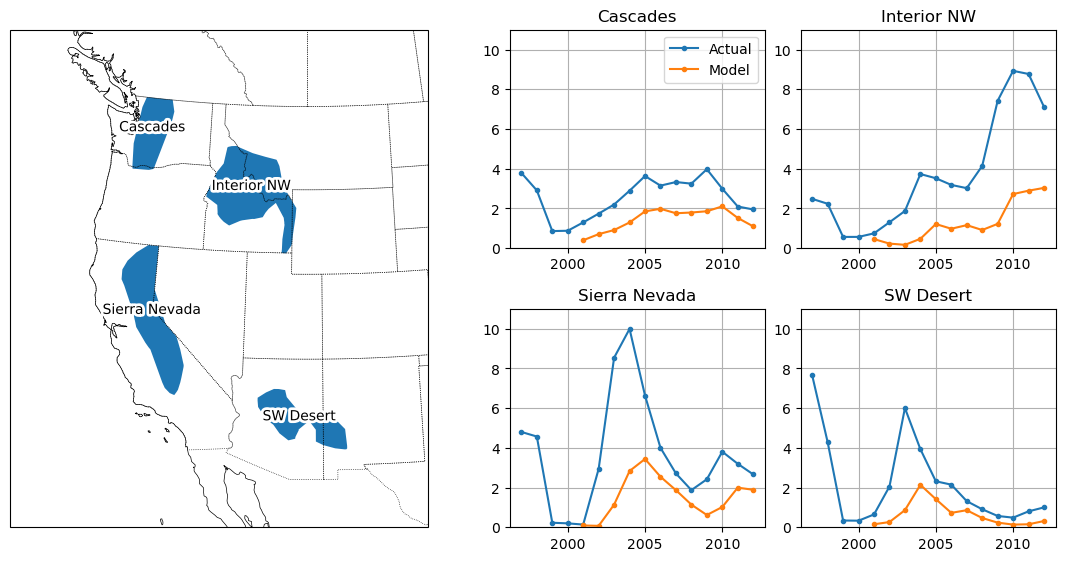

In [79]:
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as pe
import geopandas as gpd
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import shapely
from shapely.geometry import box

regions = gpd.read_file("data_in/regions_simple2.geojson")

fig = plt.Figure(layout="constrained", figsize=(11, 5.5))
gs = GridSpec(2, 3, figure=fig, width_ratios=[2, 1, 1])

projection = ccrs.AlbersEqualArea(central_latitude=42, central_longitude=-110)
map_ax = fig.add_subplot(gs[:, 0], projection=projection)

# Make the map
map_ax.coastlines(linewidth=0.5)

# Expand the bounding box a little so that we don't crop too much
mycrs = ccrs.epsg("3857")
bbox = box(*regions.total_bounds)
bbox = bbox.buffer(5e5) # meters

minx, miny, maxx, maxy = shapely.bounds(bbox)

# Add region geometries
for i in range(regions.shape[0]):
    geom = regions.geometry[i]
    map_ax.add_geometries(geom, crs=mycrs)
    map_ax.text(
        geom.centroid.x, geom.centroid.y, regions.name[i], 
        transform=mycrs,
        horizontalalignment="center",
        path_effects=[pe.withStroke(linewidth=4, foreground="white")]
    )

map_ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black', linewidth=0.5)
map_ax.set_extent((minx, maxx, miny, maxy), crs=mycrs)

axes = []

for i, (row, col) in enumerate(zip((1, 0, 1, 0), (2, 1, 1, 2))):
    ax = fig.add_subplot(gs[row, col])
    axes.append(ax)
    geom = regions.geometry[i]
    # Mean of geometric mean - no transformation necessary imo
    model = out_da.rio.write_crs(3857).rio.clip([geom]).mean(dim=["x", "y"], skipna=True).values * 100
    # Maybe do a geometric mean here?
    data  = ds_infer.sel(band="mort_ewma").rio.write_crs(3857).rio.clip([geom]).mean(dim=["x", "y"], skipna=True).values

    ax.plot(ds_infer.time, data, label="Actual", marker=".")
    ax.plot(ds_infer.time, model, label="Model", marker=".")
    ax.set_ylim(0, 11)
    ax.set_title(regions.name[i])
    ax.grid()

axes[1].legend()

fig